In [6]:
# import the necessary libraries
from rfpimp import *
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## Load Data

In [8]:
#reading in the file into pandas dataframe
df = pd.read_csv('train_reduce.csv')

# separating the target variable and the predictor variables
df_X = df.drop(columns=['hotel_cluster'])
df_y = df['hotel_cluster']

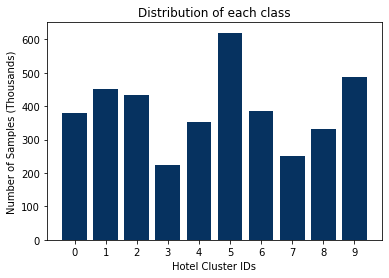

In [9]:
# Checking the distributions of each target label
clusters = []
for idx in range(0, 10):
    clusters.append(df_y.loc[(df_y == idx)].shape[0])
    
# bar graph for the number of samples per class
plt.bar([idx for idx in range(10)], [cluster/1000 for cluster in clusters], color='#063260')
plt.xticks(np.arange(10))
plt.title('Distribution of each class')
plt.xlabel('Hotel Cluster IDs')
plt.ylabel('Number of Samples (Thousands)')
plt.show()

In [10]:
# using stratified shuffle split to get 25% of the filter data while maintaing the distribution (~ 1mil samples)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.25, random_state=0)
for train_idx, test_idx in sss.split(df_X, df_y):
    X_train, X_test = df_X.iloc[train_idx], df_X.iloc[test_idx]
    y_train, y_test = df_y.iloc[train_idx], df_y.iloc[test_idx]

## Datetime Feature Engineering

In [11]:
def datetime_eng(dataframe):
    """Perform the proper datetime feature engineering on the appropriate features."""
    
    # feature engineering into datetime
    dataframe['date_time'] = pd.to_datetime(dataframe['date_time'], yearfirst=True)
    dataframe['srch_ci'] = pd.to_datetime(dataframe['srch_ci'], yearfirst=True, errors='coerce')
    dataframe['srch_co'] = pd.to_datetime(dataframe['srch_co'], yearfirst=True, errors='coerce')

    # timedelta for days in advance feature
    dataframe['advance'] = dataframe['srch_ci'] - dataframe['date_time']
    dataframe['advance'] = dataframe.advance.dt.days

    # duration of stays
    dataframe['duration'] = dataframe['srch_co'] - dataframe['srch_ci']
    dataframe['duration'] = dataframe.duration.dt.days
    
    return dataframe

In [12]:
def drop_col(dataframe):
    dataframe = dataframe.drop(columns=['user_id', 'site_name',
                               'user_location_region',
                               'date_time', 'srch_ci',
                               'srch_co'])
    return dataframe

In [13]:
# reset the index after randomly sampling a subset
sample_x = X_train.reset_index(drop=True)
sample_y = y_train.reset_index(drop=True)

# calling datetime and drop column
sample_x = datetime_eng(sample_x)
sample_x = drop_col(sample_x)

## Pipeline

In [14]:
# Train test split the data
xtrain, xtest, ytrain, ytest = train_test_split(sample_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((784124, 19), (196031, 19))

In [15]:
# Building the pipeline
def make_pipeline():
    """This function here makes the pipeline but does not include the clf to prevent data leakage."""
    
    date_features = ['advance', 'duration']
    date_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))])

    distance = ['orig_destination_distance']
    distance_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    preprocessor = ColumnTransformer(transformers=[('date', date_transformer, date_features),
                                                   ('dist', distance_transformer, distance)],
                                                   remainder='passthrough')
    
    return preprocessor

In [16]:
def make_random_cv(cv, n_iter, n_estimators):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                random_state=42, 
                                max_depth=10, 
                                oob_score=True,
                                n_jobs=4)
    
    params_grid = {'max_features': [2, 5, 10, 16],
                  'min_samples_leaf': [100, 500, 1000, 2000]}
    
    clf_random_cv = RandomizedSearchCV(estimator=rf, scoring='precision_weighted',
                                       param_distributions=params_grid,
                                       n_iter=n_iter, cv=cv)
                                         
    return clf_random_cv

In [18]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.transform(xtest)
trans_xtrain.shape  # sanity check of datashape

(784124, 19)

## Baseline Models with different ML Algorithms
Evaluated on accuracy and precision but focusing on maximizing precision to make sure expedia can predict customer behavior as much as possible.

### Random Forest

In [52]:
# creating the RandomizedSearchCV and using the best estimator
randomize_clf = make_random_cv(3, 5, 2)  # 3-fold, 5 iterations
randomize_clf.fit(trans_xtrain, ytrain)
best_rf = randomize_clf.best_estimator_  # returning the best estimator
randomize_clf.best_params_

{'min_samples_leaf': 100, 'max_features': 16}

In [55]:
# fitting the best estimator and getting the training scores
best_rf.fit(trans_xtrain, ytrain)
print(f"Out-of-Bag Accuracy: {best_rf.oob_score_}")
print(f"Train Accuracy: {accuracy_score(ytrain, best_rf.predict(trans_xtrain))}")
print(f"Test Accuracy: {accuracy_score(ytest, best_rf.predict(trans_xtest))}")

Out-of-Bag Accuracy: 0.3623470267457698
Train Accuracy: 0.5551596431176702
Test Accuracy: 0.5542541740847111


In [54]:
# getting the test precision scores
print(f"Training weighted-precision-score: {precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-precision-score: {precision_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

Training weighted-precision-score: 0.5513450596255041
Testing weighted-precision-score: 0.5507317153780125


### Decision Tree

In [19]:
dt = DecisionTreeClassifier()
dt.fit(trans_xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, dt.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, dt.predict(trans_xtest))}")

In [ ]:
# Training Classification Report
print(classification_report(ytrain, dt.predict(trans_xtrain)))

In [ ]:
# Testing Classification Report
print(classification_report(ytest, dt.predict(trans_xtest)))

### Logistic Regression

In [20]:
def make_pipelines_lr():
    pipe_log = Pipeline([('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs' ))])
    pipelines = [pipe_log]
    
    return pipelines

In [21]:
pipelines_lr = make_pipelines_lr()

In [22]:
#precision score
def sort_models_precision(pipelines, X_data, y_data, metric=accuracy_score, average="weighted"):
    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred, average=average), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [23]:
sort_models_precision(pipelines_lr, trans_xtest, ytest, metric=precision_score)

test socre with LogisticRegression is 0.12


[('LogisticRegression', 0.12)]

In [24]:
#accuracy score
def sort_models_accuracy(pipelines, X_data, y_data, metric=accuracy_score):
    score = []
    
    for pipe in pipelines:
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        pipe.fit(X_data, y_data)
        y_train_pred = pipe.predict(X_data)
        accuracy = round(metric(y_data, y_train_pred), 2)
        score.append((name, accuracy))

    for model in score:
        print(f"test socre with {model[0]} is {model[1]}")
        
    return score

In [25]:
sort_models_accuracy(pipelines_lr, trans_xtest, ytest, metric=accuracy_score)

test socre with LogisticRegression is 0.19


[('LogisticRegression', 0.19)]

### KNN

In [26]:
def make_pipelines_knn():
    pipe_knn = Pipeline([('scl', StandardScaler()),('clf', KNeighborsClassifier())])
    
    pipelines = [pipe_knn]
    
    return pipelines

In [27]:
pipelines_knn = make_pipelines_knn()

In [ ]:
sort_models_precision(pipelines_knn, trans_xtest, ytest, metric=precision_score)

In [ ]:
sort_models_accuracy(pipelines_knn, trans_xtest, ytest, metric=accuracy_score)

## Hyperparameter Tuning 

### Random Forest (1 million samples)

In [ ]:
# creating the RandomizedSearchCV and using the best estimator
best_params = []
oob_scores = []
precision_train = []
precision_test = []
train_acc = []
test_acc = []

for n in tqdm([1, 5, 10, 20, 50, 100]):
    randomize_clf = make_random_cv(cv=3, n_iter=5, n_estimators=n)  # 3-fold, 5 iterations
    randomize_clf.fit(trans_xtrain, ytrain)
    best_rf = randomize_clf.best_estimator_  # returning the best estimator
    
    # fitting the best estimator and getting the training scores
    best_rf.fit(trans_xtrain, ytrain)
    train_acc.append(accuracy_score(ytrain, best_rf.predict(trans_xtrain)))  # train_acc
    test_acc.append(accuracy_score(ytest, best_rf.predict(trans_xtest)))  # test_acc
    oob_scores.append(best_rf.oob_score_)  # list of oob scores
    best_params.append(randomize_clf.best_params_)  # creating a list of best params
    precision_train.append(precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'))
    precision_test.append(precision_score(ytest, best_rf.predict(trans_xtest), average='weighted'))

In [ ]:
# Accuracy Plots
n_trees = [1, 5, 10, 20, 50, 100]
plt.plot(n_trees, train_acc, label='train')
plt.plot(n_trees, test_acc, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Scores')
plt.title('Number of Trees vs Accuracy Scores')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Precision plots
plt.plot(n_trees, precision_train, label='train')
plt.plot(n_trees, precision_test, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Weighted Precision Scores')
plt.title('Number of Trees vs Weighted Precision Scores')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# best set of hyperparameters for n_trees
for n, param in zip(n_trees, best_params):
    print(f"Best parameters for {n} Trees: {param}")

In [ ]:
# Training the best model according to the plots and randomize search
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

In [ ]:
# Accuracy scores
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

In [ ]:
# Precision scores
print(f"Training weighted-precision-score: {precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-precision-score: {precision_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

In [ ]:
# F1-scores
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-f1-Score: {f1_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

In [ ]:
# Training Classification Report
print(classification_report(ytrain, rf.predict(trans_xtrain)))

In [ ]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

In [ ]:
# Feature importance
features = ['posa_continent', 'user_location_country', 'user_location_city',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'advance',
       'duration']
df_imp = pd.DataFrame(trans_xtest, columns=features)

In [ ]:
imp = importances(rf, df_imp, ytest)
viz = plot_importances(imp)
viz.view()

### Decision Tree (1 million samples)

In [ ]:
num_max_depths = np.arange(1,33)
accuracy_train = []
accuracy_test = []
for depth in num_max_depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(trans_xtrain, ytrain)
    
    acc_train = accuracy_score(ytrain, dt.predict(trans_xtrain))
    accuracy_train.append(acc_train)
    
    acc_test = accuracy_score(ytest, dt.predict(trans_xtest))
    accuracy_test.append(acc_test)
    
line1 = plt.plot(num_max_depths, accuracy_train, "b", label= "Train accuracy")
line2 = plt.plot(num_max_depths, accuracy_test, "r", label= "Test accuracy")

plt.title("Tree Depth vs Accuracy")
plt.ylabel("Accuracy Score")
plt.xlabel("Tree Depth")
plt.show()

## Best Model (full dataset)

In [ ]:
# Reset the index
sample_x = df_X.reset_index(drop=True)
sample_y = df_y.reset_index(drop=True)

# Calling datetime and drop column
sample_x = datetime_eng(sample_x)
sample_x = drop_col(sample_x)

In [ ]:
# Train test split on the data
xtrain, xtest, ytrain, ytest = train_test_split(sample_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

In [ ]:
# Make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtest = pipeline.transform(xtest)

In [ ]:
# Training the best model according to the plots with more depths (15) (100, 16)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_features=16,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

In [ ]:
# Accuracy Score
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"Out of Bag Accuracy: {rf.oob_score_}")

In [ ]:
# Precision scores
print(f"Training weighted-precision-score: {precision_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")
print(f"Testing weighted-precision-score: {precision_score(ytest, best_rf.predict(trans_xtest), average='weighted')}")

In [ ]:
# F1-scores
print(f"Training weighted-f1-Score: {round(f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'), 2)}")
print(f"Testing weighted-f1-Score: {round(f1_score(ytest, best_rf.predict(trans_xtest), average='weighted'), 2)}")

In [ ]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

## Summary
